In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.integrate as integrate
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.style.use("default")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
    }
)

n_dense_points = 201

In [2]:
def Exact(t, y):
    """Exact equation y' = (t**2+t*y+y**2)/t**2
    """
    return (t**2+t*y+y**2)/t**2

def Exact_exact(t, y0):
    return t*np.tan(np.log(t)+np.arctan(y0))

In [3]:
domain = (1, 2)
t0 = 1.0
y0 = 0.0

t_dense = np.linspace(*domain, n_dense_points)

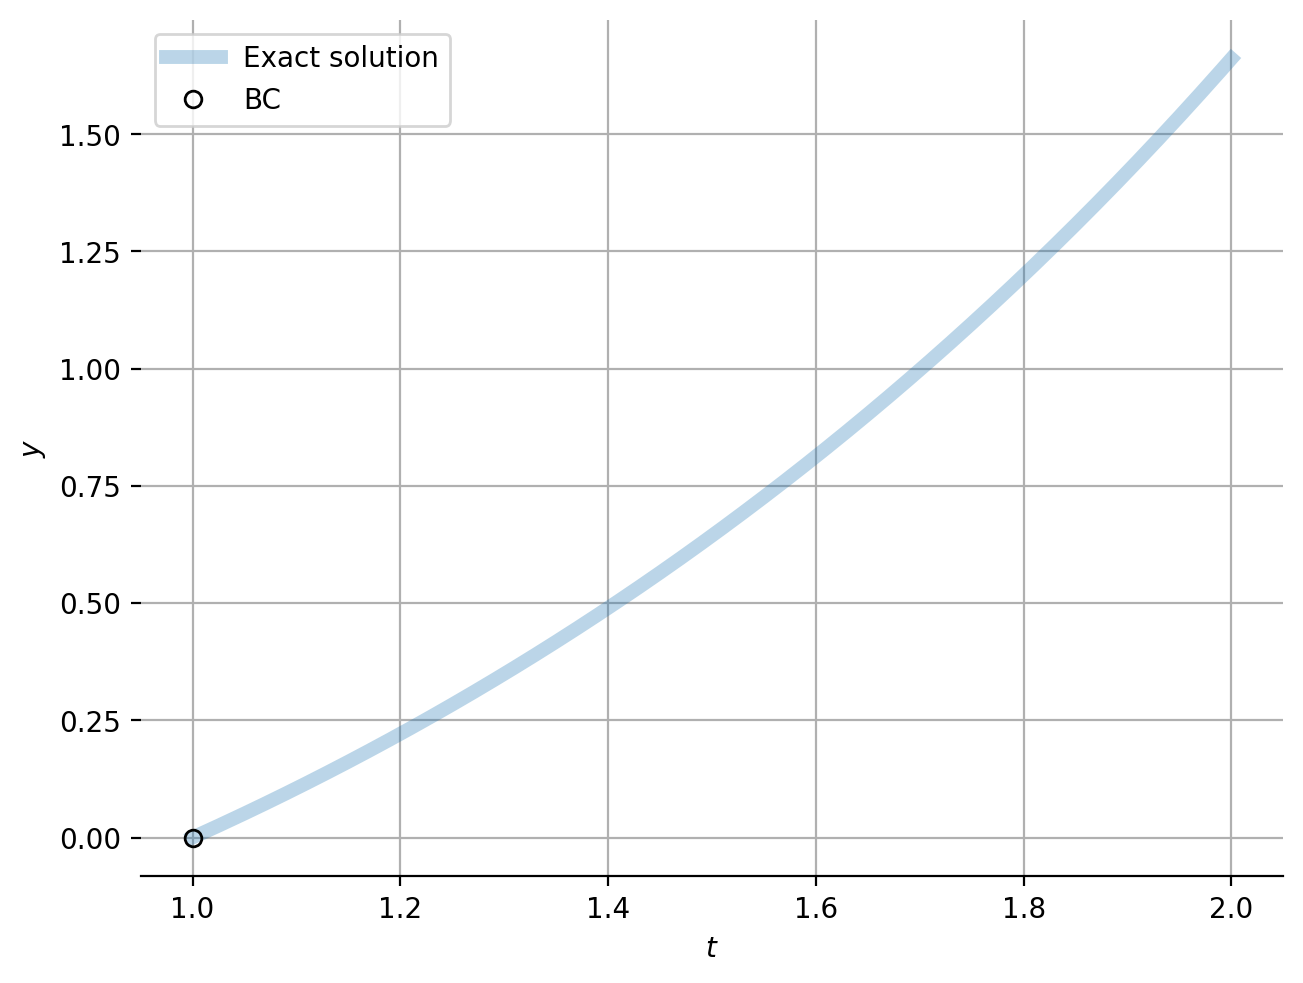

In [4]:
y_exact = Exact_exact(t_dense, y0)

fig, ax = plt.subplots()
ax.plot(t_dense, y_exact, c="C0", linewidth=5, alpha=0.3, label="Exact solution")
ax.plot(t0, y0, "ko", mfc="none", label="BC")
ax.set(
    xlabel=r"$t$",
    ylabel=r"$y$",
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)

In [5]:
class MLP(nn.Module):
    def __init__(self, *features, activation=nn.Tanh):
        super().__init__()

        layers = []
        for in_features, out_features in zip(features, features[1:]):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation())
        self.network = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.network(x)

In [6]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

In [7]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
print(model)

MLP(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [8]:
batch_size = 10000
n_epochs = 1_000
print_interval = n_epochs // 10
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)


loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = model(t)
    y_e=t*torch.tan(torch.log(t))

    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss((t**2+t*y+y**2)/t**2- y_t, torch.zeros_like(y_t))
    loss_bc = F.mse_loss(model(torch.tensor([[t0]])), torch.tensor([[y0]]))
    loss = loss_de + loss_bc
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))**0.5
    # Backprop
    loss.backward()
    loss = loss_de**0.5 + loss_bc**0.5
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())

    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_bc = {loss_bc.item():.4f}, loss = {loss.item():.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.6573, loss_bc = 0.1534, loss = 1.6790
epoch = 100, loss_de = 0.0908, loss_bc = 0.0437, loss = 0.5104
epoch = 200, loss_de = 0.0835, loss_bc = 0.0405, loss = 0.4902
epoch = 300, loss_de = 0.0804, loss_bc = 0.0401, loss = 0.4837
epoch = 400, loss_de = 0.0794, loss_bc = 0.0399, loss = 0.4816
epoch = 500, loss_de = 0.0807, loss_bc = 0.0399, loss = 0.4839
epoch = 600, loss_de = 0.0792, loss_bc = 0.0399, loss = 0.4811
epoch = 700, loss_de = 0.0793, loss_bc = 0.0399, loss = 0.4813
epoch = 800, loss_de = 0.0800, loss_bc = 0.0399, loss = 0.4826
epoch = 900, loss_de = 0.0799, loss_bc = 0.0399, loss = 0.4825


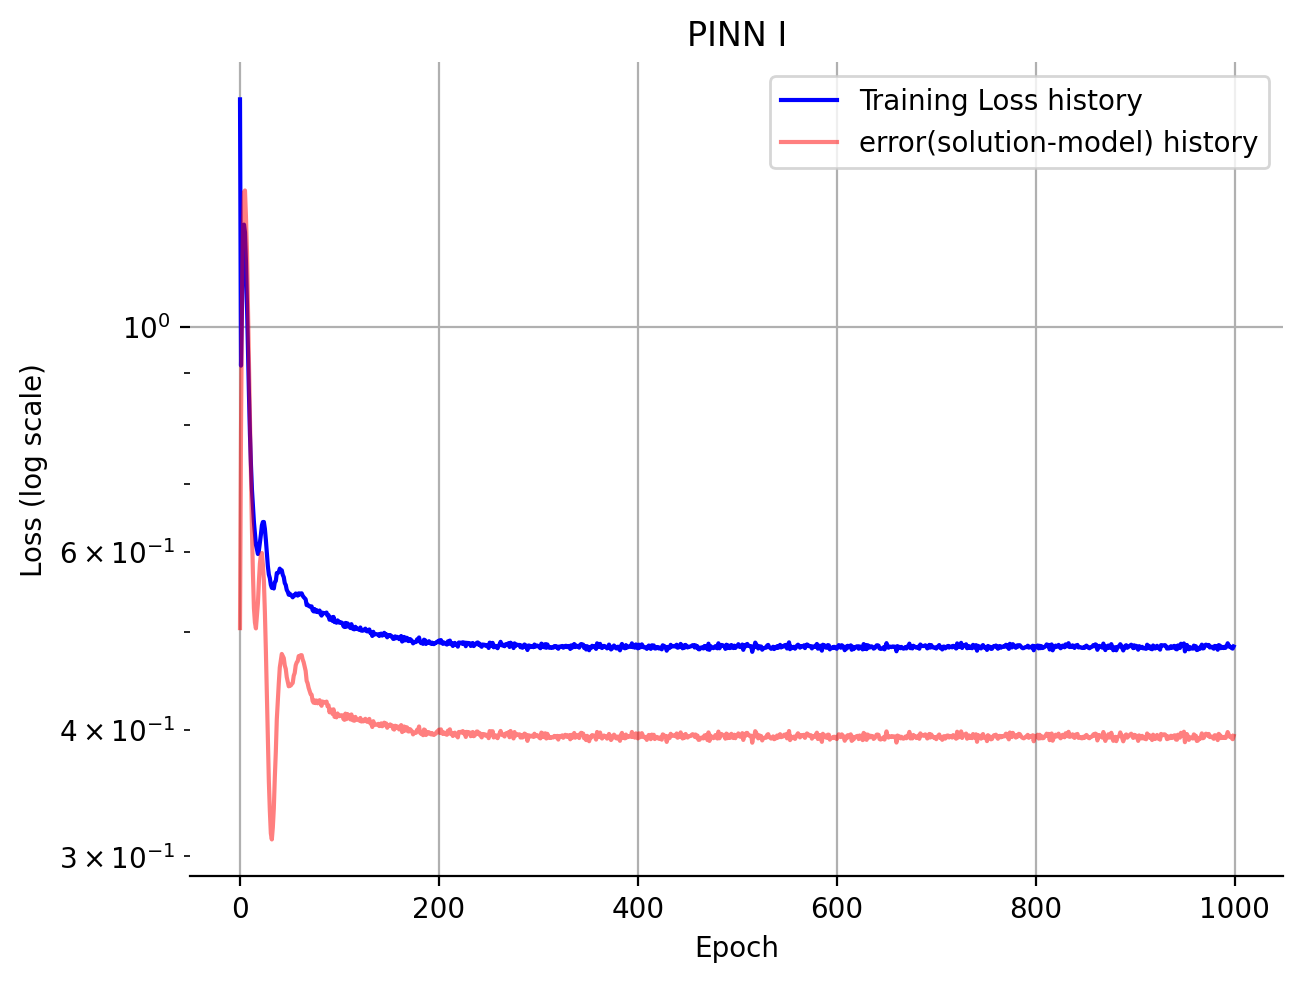

In [9]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN I"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [10]:
X=np.array(loss_history)
Y=np.array(realloss_history)

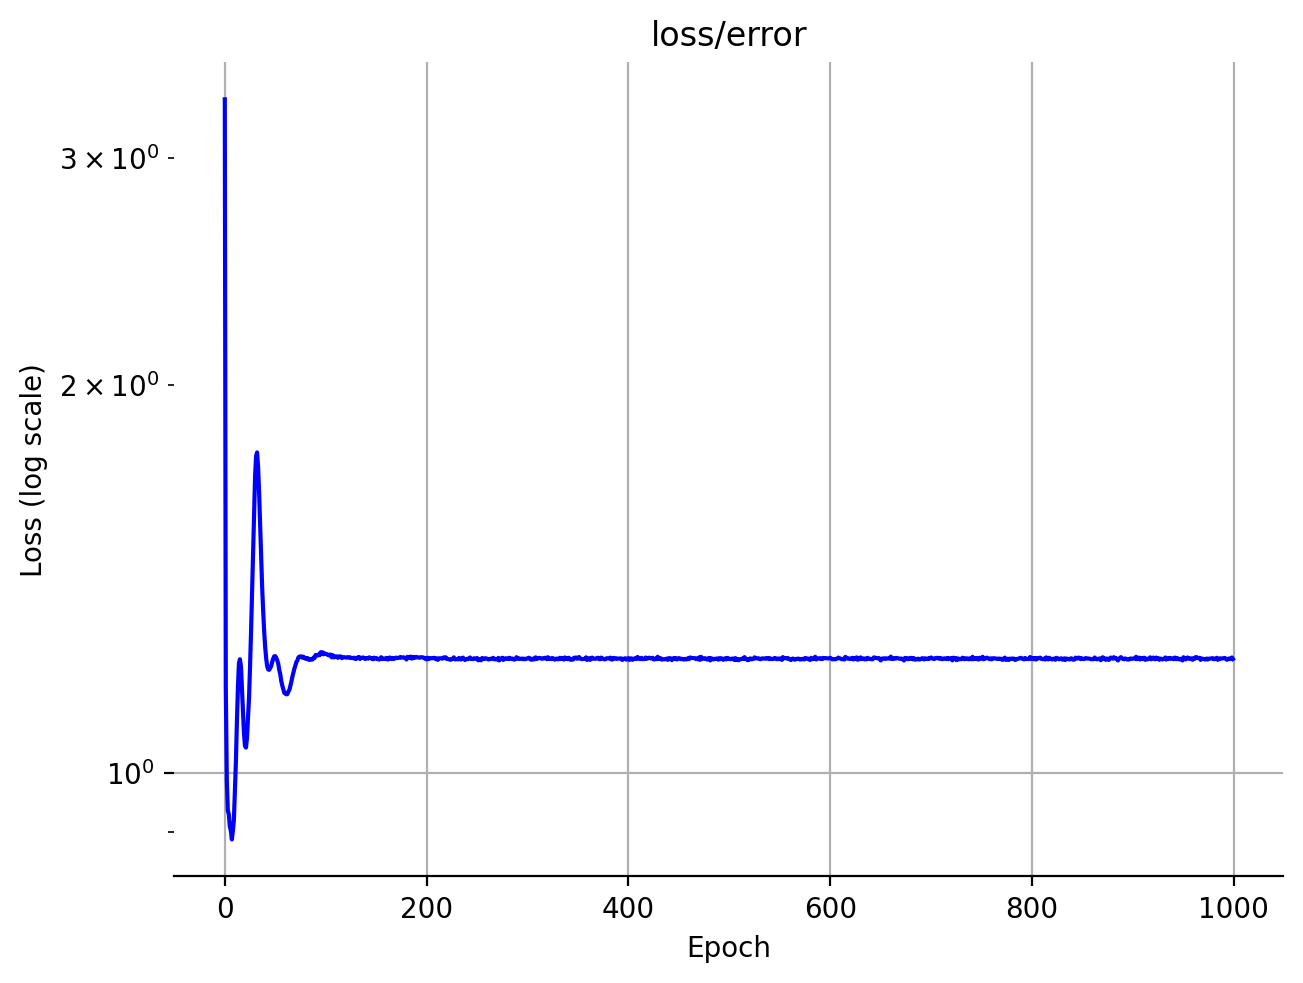

In [11]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

In [12]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
print(model)

MLP(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [13]:
batch_size = 10000
n_epochs = 1_000
print_interval = n_epochs // 10
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = (t-1)*model(t)
    y_e= t*torch.tan(torch.log(t))
    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss((t**2+t*y+y**2)/t**2 - y_t, torch.zeros_like(y_t))
    loss_bc = F.mse_loss(model(torch.tensor([[t0]])), torch.tensor([[y0]]))
    loss = loss_de
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))**0.5
    # Backprop
    loss.backward()
    loss = loss_de**0.5
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_bc = {loss_bc.item():.4f}, loss = {loss.item():.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 0.4273, loss_bc = 0.1534, loss = 0.6537
epoch = 100, loss_de = 0.0059, loss_bc = 0.6821, loss = 0.0770
epoch = 200, loss_de = 0.0056, loss_bc = 0.6876, loss = 0.0747
epoch = 300, loss_de = 0.0056, loss_bc = 0.6887, loss = 0.0752
epoch = 400, loss_de = 0.0054, loss_bc = 0.6891, loss = 0.0736
epoch = 500, loss_de = 0.0055, loss_bc = 0.6892, loss = 0.0738
epoch = 600, loss_de = 0.0053, loss_bc = 0.6892, loss = 0.0729
epoch = 700, loss_de = 0.0055, loss_bc = 0.6892, loss = 0.0739
epoch = 800, loss_de = 0.0054, loss_bc = 0.6892, loss = 0.0737
epoch = 900, loss_de = 0.0055, loss_bc = 0.6892, loss = 0.0739


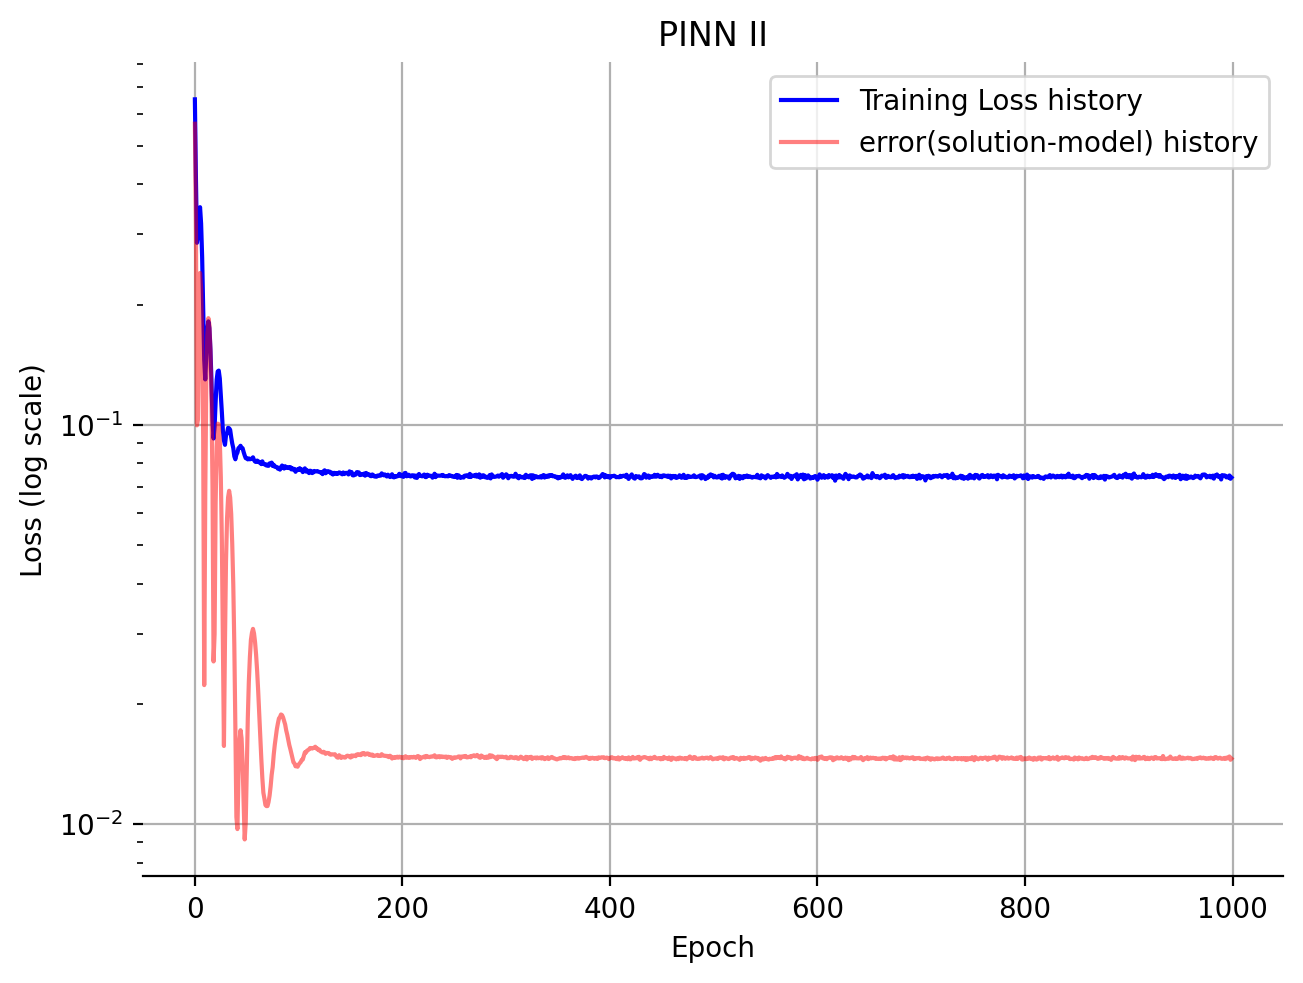

In [14]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN II"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [15]:
X=np.array(loss_history)
Y=np.array(realloss_history)

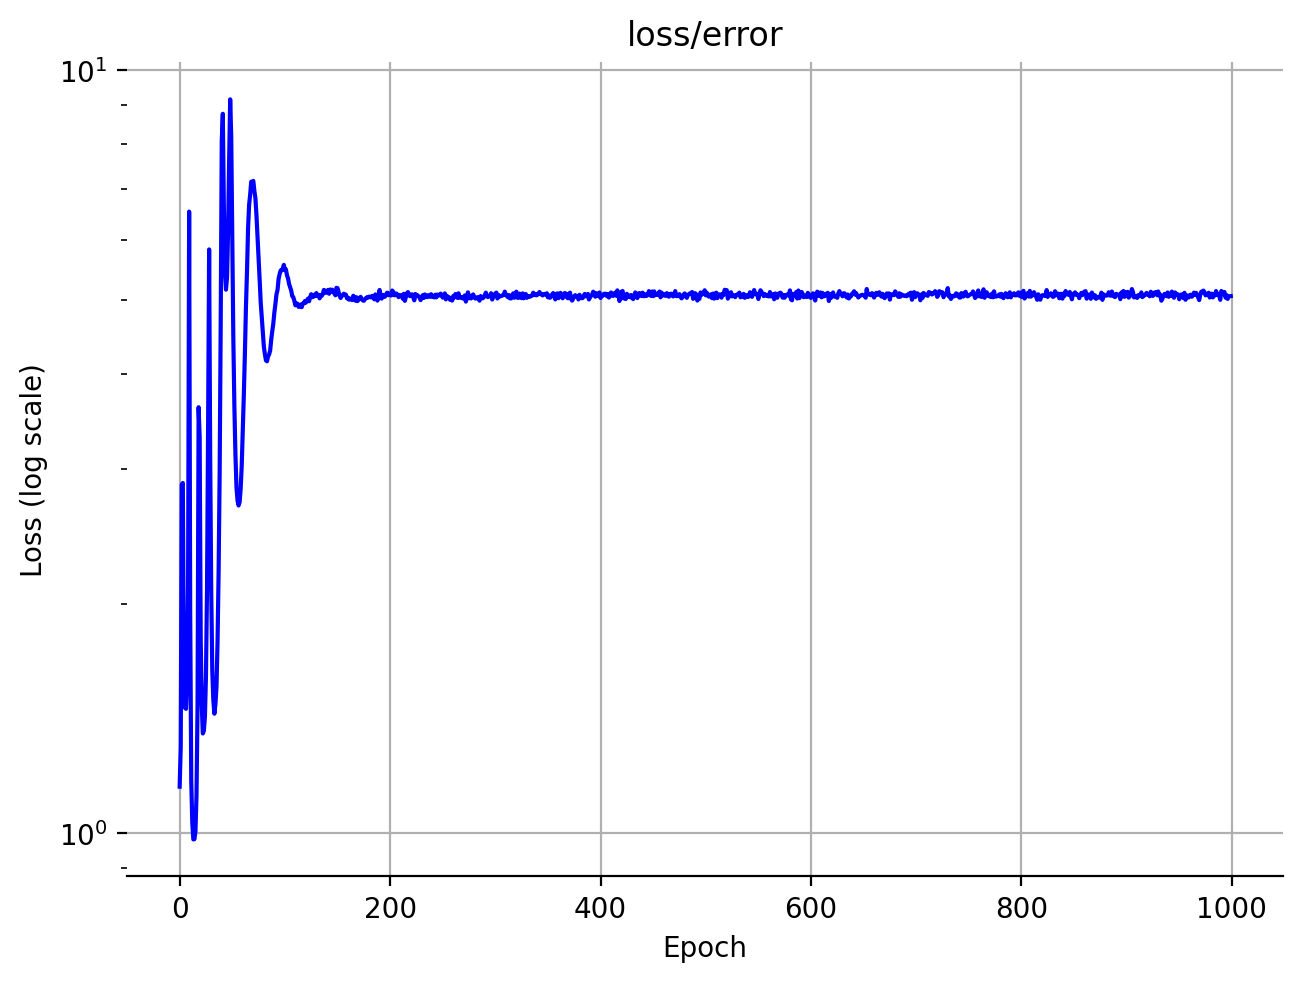

In [16]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass